In [10]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

# .py
%load_ext autoreload
%autoreload 2
import weather_all_alphas, weather_all_costs, prediction_humidity, model_02, validate, dengue_weather

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def seperate_train_test(all_data, train_data, peak):
    peak_for_txt = peak -10
    plt.axvspan(0, len(train_data), color='blue', alpha=0.1)
    plt.text((len(train_data)/2)-25,peak_for_txt,'Train Period',size=16)
    plt.axvline(len(train_data)+1,linewidth=0.5, color='green')
    plt.text(len(train_data)+20,peak_for_txt,'Test Period',size=16)
    plt.axvspan(len(train_data)+1, len(all_data), color='green', alpha=0.1)

def plot_all_predictions(LAG, real, train, province, nweeks_to_predict, all_predictions):
    
    plt.figure(figsize=(13,6))
    plt.plot(range(len(real)),real.cases,label='real')
    graph_title = "%s's Dengue Prediction with Weather Data"%province
    plt.title(graph_title)
    for i in range(len(all_predictions)):
        cur_week_guess = nweeks_to_predict[i]
        start_predict_week = LAG+(cur_week_guess-1)
        predicted_cases = all_predictions[i]
        x_weeks = range(start_predict_week,len(predicted_cases)+start_predict_week)
        line_label = "%d week guess"%cur_week_guess
        plt.plot(x_weeks,predicted_cases,label=line_label,alpha=0.8)
    
    real_max = real.cases.max()
    train_max = train.cases.max()
    peak = max(real_max,train_max)
    seperate_train_test(real,train,peak)
    plt.axvline(LAG)
    plt.text((LAG*2)+10,peak/2,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel("# week starting 2003")
    plt.ylabel("Dengue cases")
    plt.legend(loc='best')
    img_name = "prediction-for-%s.pdf"%(province)
    plt.savefig(img_name)
    
def show_predictions(params, real, train, province, ws):
    LAG, TEMPERATURE_WEEKS, RAIN_WEEKS, AVGRH_WEEKS = params[0], params[1], params[2], params[3]
    
    predictions_to_plot = prediction_humidity.get_predictions(
        LAG, 
        TEMPERATURE_WEEKS,
        RAIN_WEEKS,
        AVGRH_WEEKS,
        real,
        ws,
        province)
    
    plot_all_predictions(LAG, 
                         real,
                         train,
                         province,
                         [1,2,4,8,16],
                         predictions_to_plot)


In [4]:
all_weather = pd.read_csv("weather01-16.csv")
all_weather.stn_name = all_weather.stn_name.apply(dengue_weather.remove_space)
all_dengue = pd.read_csv("all-dengues.csv")
all_dengue = all_dengue.rename(columns = {'จังหวัด' : 'province'})

In [5]:
                       # province_dengue: province_weather
provinces_to_predict = {#"Bangkok":"BangkokMetropolis",
                        "PrachuapKhiriKhan":"PrachuapKhiriKhan",
                        "PhraNakhonSiAyutthaya":"AyuttayaAgromet", 
                        "Songkhla":"PhatthalungAgromet", 
                        "Ratchaburi":"Ratchaburi", 
                        "ChonBuri":"ChonBuri", 
                        "NongKhai":"NongKhai",
                        "SakonNakhon":"SakonNakhonAgromet",
                        "ChiangMai":"ChiangMai",
                        "ChiangRai":"ChiangRai",
                        #"Pathumthani":"PathumthaniAgromet",
                        "SamutPrakan":"PilotStation",
                        "NakhonPathom":"KamphaengSaenAgromet", 
                        "MahaSarakham":"KosumPhisai",  
                        "Pattani":"PattaniAirport", 
                        "SuratThani":"SuratThaniAgromet"}

province_data = {}
for province_for_dengue in provinces_to_predict:
    province_for_weather = provinces_to_predict.get(province_for_dengue)
    print province_for_dengue, province_for_weather
    
    province_data_to_predict = dengue_weather.get_dengue_weather_by_province(
                                                                    province_for_dengue, 
                                                                    province_for_weather, 
                                                                    all_dengue, 
                                                                    all_weather)
    province_data[province_for_dengue] = province_data_to_predict
    
# province data is dictionary of province to its train and real data, idx 0 and 1
# ex --> province_data.get('Bangkok')[0]

PhraNakhonSiAyutthaya AyuttayaAgromet
SamutPrakan PilotStation
SuratThani SuratThaniAgromet
ChiangRai ChiangRai
ChiangMai ChiangMai
ChonBuri ChonBuri
Pattani PattaniAirport
Songkhla PhatthalungAgromet
Ratchaburi Ratchaburi
NongKhai NongKhai
SakonNakhon SakonNakhonAgromet
PrachuapKhiriKhan PrachuapKhiriKhan
MahaSarakham KosumPhisai
NakhonPathom KamphaengSaenAgromet


### perform error testing on test data

In [6]:
def get_distances(LAG, all_predictions, real):

    def distance(prediction, real):
        all_residual = prediction - real
        return all_residual

    weeks = [1,2,4,8,16]
    ret = []
    for idx,prediction in enumerate(all_predictions):
        cur_pred = np.array(prediction)
        # compare with real
        # doesnt take into the accout of the predicted week(s)
        cur_pred_range = cur_pred[:-weeks[idx]]
        real_range = real.cases[LAG+weeks[idx]:]
        ret.append(distance(cur_pred_range,real_range))

    return ret

In [7]:
%%time
chosen_ws = glob.glob("province-ws-*.csv")
test_err = []
for ws_set_file in chosen_ws:
    raw_cur_ws = pd.read_csv(ws_set_file).T
    cur_ws = np.array(raw_cur_ws)[0]
    cur_province = ws_set_file[16:-4]
    cur_train = province_data[cur_province][0]
    cur_real = province_data[cur_province][1]
    cur_test = province_data[cur_province][2]
#     print "cur_province", cur_province
#     print "cur_test", len(cur_test)
    
    predictions_to_validate = prediction_humidity.get_predictions(
        19,9,15,1,
        cur_test,
        cur_ws)
    
    cur_test_err = get_distances(
        19,
        predictions_to_validate,
        cur_test)
    
    test_err.append(cur_test_err)
    
#     show_predictions(
#                     [19,9,15,1],
#                     cur_real,
#                     cur_train,
#                     cur_province,
#                     cur_ws)

CPU times: user 15.6 s, sys: 137 ms, total: 15.8 s
Wall time: 16 s


In [15]:
len(test_err[0])

5

### use chiang mai parameter for chiang rai

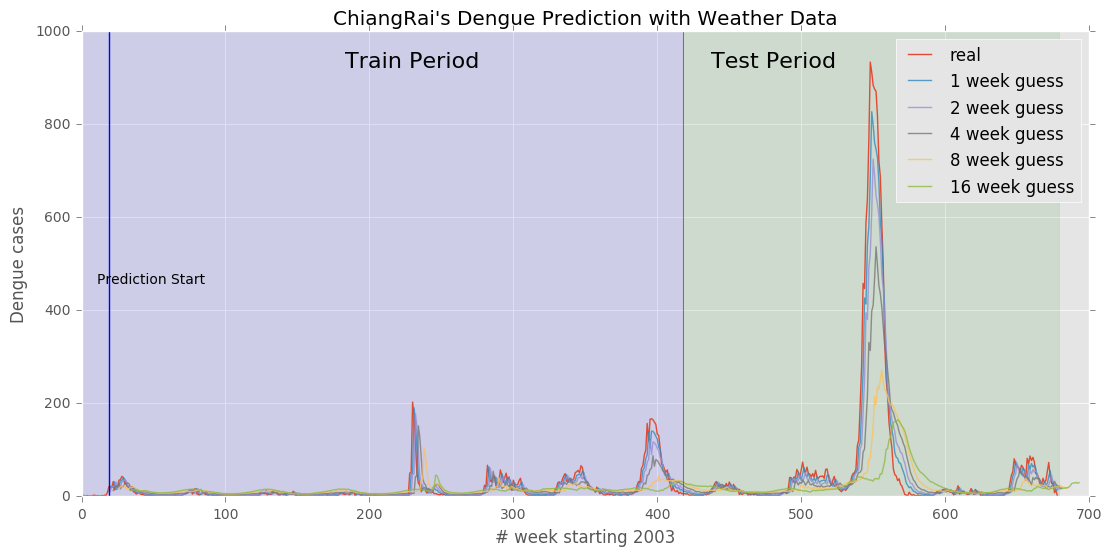

In [307]:
# raw_cm_ws = pd.read_csv("province-ws-for-ChiangMai.csv").T
# cm_ws = np.array(raw_cur_ws)[0]
# to_fix_province = "ChiangRai"
# cr_train = province_data[to_fix_province][0]
# cr_real = province_data[to_fix_province][1]
# show_predictions(
#                 [19,9,15,1],
#                 cr_real,
#                 cr_train,
#                 to_fix_province,
#                 cm_ws)


In [8]:
arr = []
for i_idx in range(len(test_err[0])):
    tmp = []
    for j_idx in range(len(test_err)):
        tmp.append(test_err[j_idx][i_idx])
    concat_tmp = np.append([],tmp)
    arr.append(concat_tmp)
    
predicted_weeks = pd.DataFrame(arr).T
predicted_weeks.columns = ['1_week','2_weeks','4_weeks','8_weeks','16_weeks']

0.967827626919
0.969598583235
0.961629279811
0.948642266824
0.917650531287


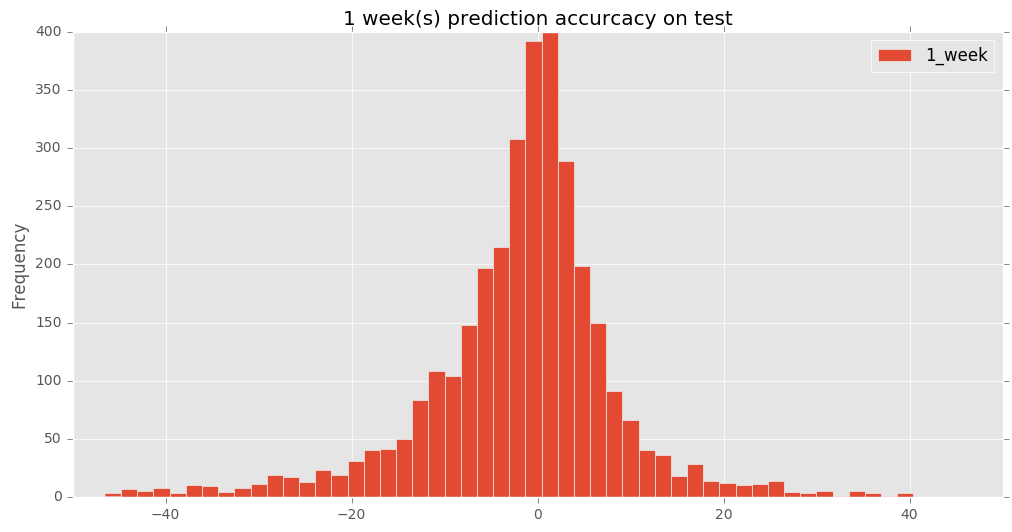

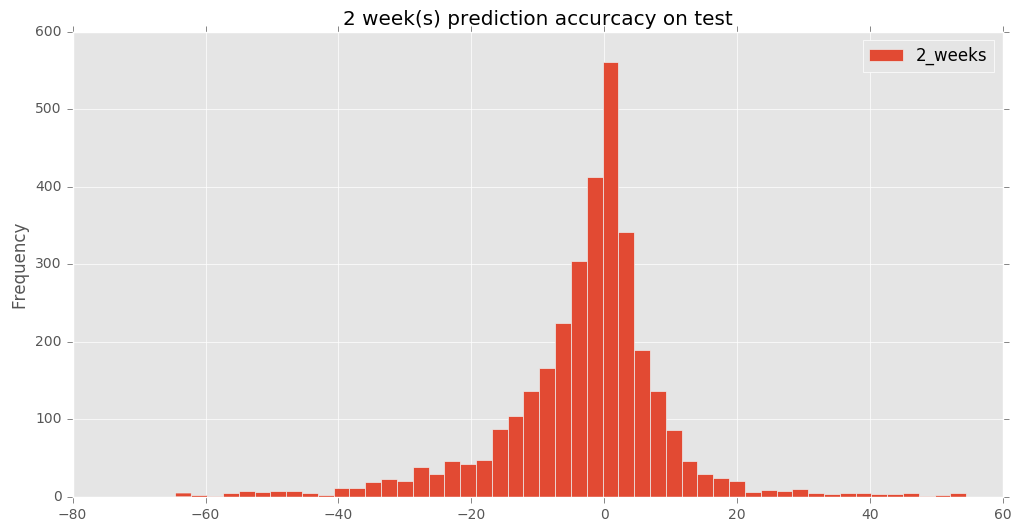

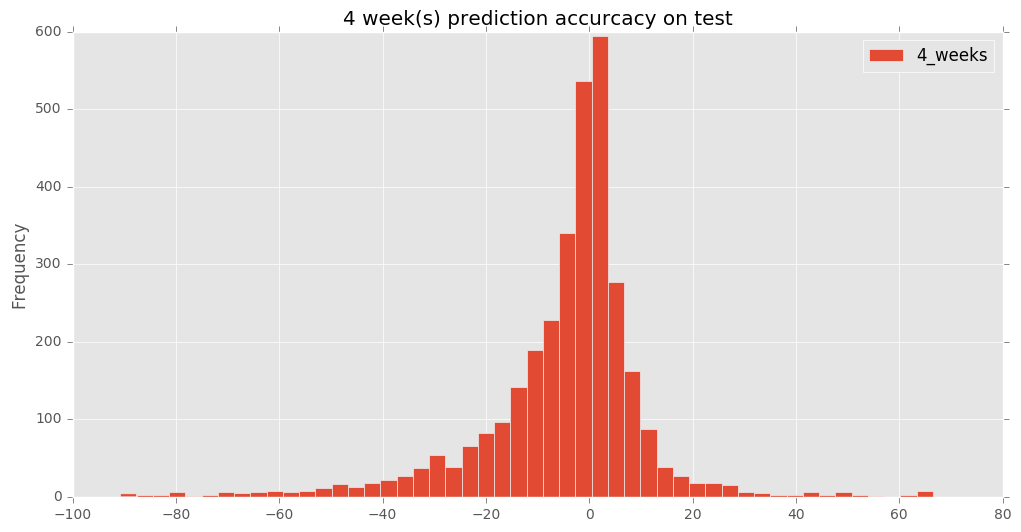

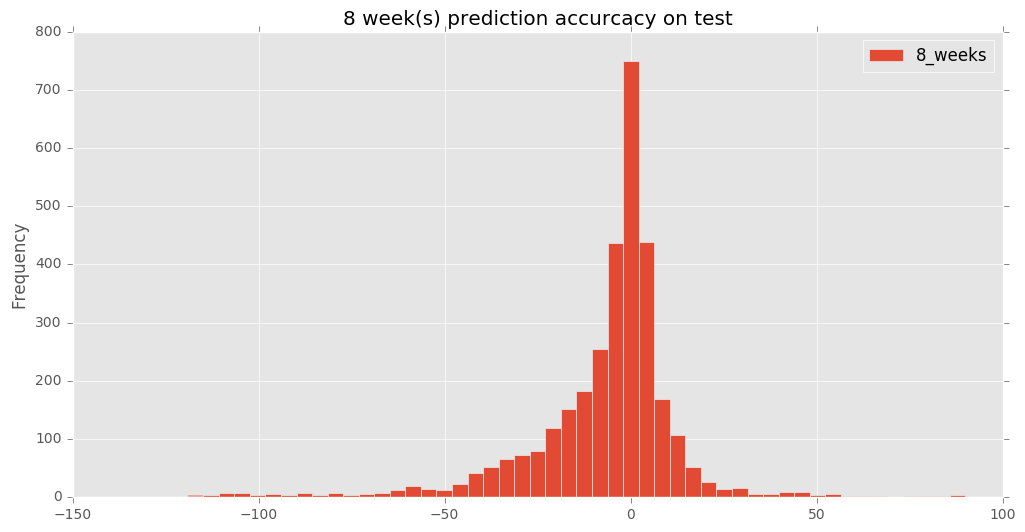

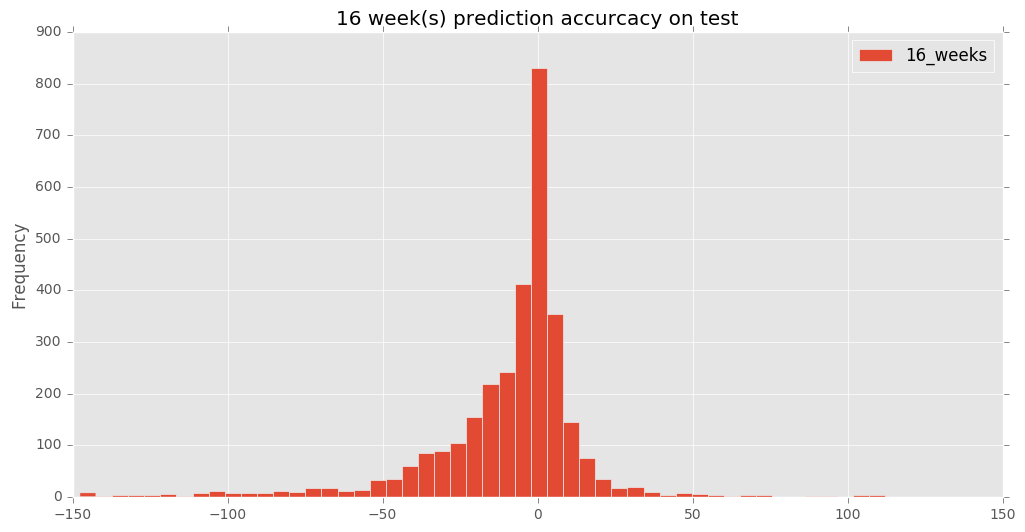

In [20]:
def get_two_std_away(cur_predicted_weeks):
    cur_week_data = cur_predicted_weeks
    cur_week_mean = cur_week_data.mean()
    cur_week_std = cur_week_data.std()
    two_std = (cur_week_std*2)
    lower_bnd, upper_bnd = cur_week_mean - two_std, cur_week_mean + two_std
    cur_week_data_df = pd.DataFrame(cur_week_data)
    two_std_mask = (cur_week_data_df >= lower_bnd) & (cur_week_data_df <= upper_bnd)
    final_cur_week_data_df = pd.DataFrame(cur_week_data_df[two_std_mask])
    final_cur_week_data_df = final_cur_week_data_df.dropna()
    return final_cur_week_data_df

weeks_predicted = [1,2,4,8,16]
for idx, week in enumerate(weeks_predicted):
    cur_distance_away_data = predicted_weeks.iloc[:,idx]
    two_std_away_data = get_two_std_away(cur_distance_away_data)
    
    title = "%d week(s) prediction accurcacy on test"%(week)    
    two_std_away_data.plot(kind="hist",bins=50,title=title,figsize=(12,6))
    print len(two_std_away_data) / float(len(cur_distance_away_data))
    

In [314]:
def get_deviations(LAG, all_predictions, real):
    
    def deviation(prediction, real):
        deviations_dict = {}
        for idx,real_case in enumerate(real):
            residual = real_case - prediction[idx]
#             sigma = (real_case+10)**0.5 

            score = residual / (real_case+1)
            score_arr = [score]

            if deviations_dict.has_key(real_case):
                deviations_dict[real_case].append(score)
            else:
                deviations_dict[real_case] = score_arr

        return deviations_dict
    
    def deviation_avg(in_dict):
        ret_dict = {}
        for key in in_dict:
            all_std = in_dict[key]
            avg_std = np.array(all_std).mean()
            ret_dict[key] = avg_std
        return ret_dict


    weeks = [1,2,4,8,16]
    ret = []
    for idx,prediction in enumerate(all_predictions):
        cur_pred = np.array(prediction)
        # compare with real
        # doesnt take into the accout of the predicted week(s)
        cur_pred_range = cur_pred[:-weeks[idx]]
        real_range = real.cases[LAG+weeks[idx]:]
        raw_deviation_real_cases = deviation(cur_pred_range,real_range)
        avg_deviation_real_cases = deviation_avg(raw_deviation_real_cases)
        ret.append(avg_deviation_real_cases)
        

    return ret

In [315]:
# number of cases
test_std = []
for ws_set_file in chosen_ws:
    raw_cur_ws = pd.read_csv(ws_set_file).T
    cur_ws = np.array(raw_cur_ws)[0]
    cur_province = ws_set_file[16:-4]
    cur_train = province_data[cur_province][0]
    cur_real = province_data[cur_province][1]
    cur_test = province_data[cur_province][2]
    
    print cur_province
    
#     """see how unique real cases there are"""
#     a = np.array(cur_test.cases.unique())
#     print len(np.sort(a))
    
#     print cur_test.tail()
    
    predictions_to_validate = prediction_humidity.get_predictions(
        19,9,15,1,
        cur_test,
        cur_ws)
    
    cur_test_std = get_deviations(
        19,
        predictions_to_validate,
        cur_test)
    
    test_std.append(cur_test_std)

ChiangMai
ChiangRai
ChonBuri
MahaSarakham
NakhonPathom
NongKhai
Pattani
PhraNakhonSiAyutthaya
PrachuapKhiriKhan
Ratchaburi
SakonNakhon
SamutPrakan
Songkhla
SuratThani


In [316]:
all_weeks_arr = []
for i_idx in range(len(test_std[0])):
    cur_week_arr = []
    for j_idx in range(len(test_std)):
        temp_df = pd.DataFrame(test_std[j_idx][i_idx].values()).T
        temp_df.columns = test_std[j_idx][i_idx].keys()
        cur_week_arr.append(temp_df)
    cur_week_df = pd.concat(cur_week_arr)
    all_weeks_arr.append(cur_week_df)



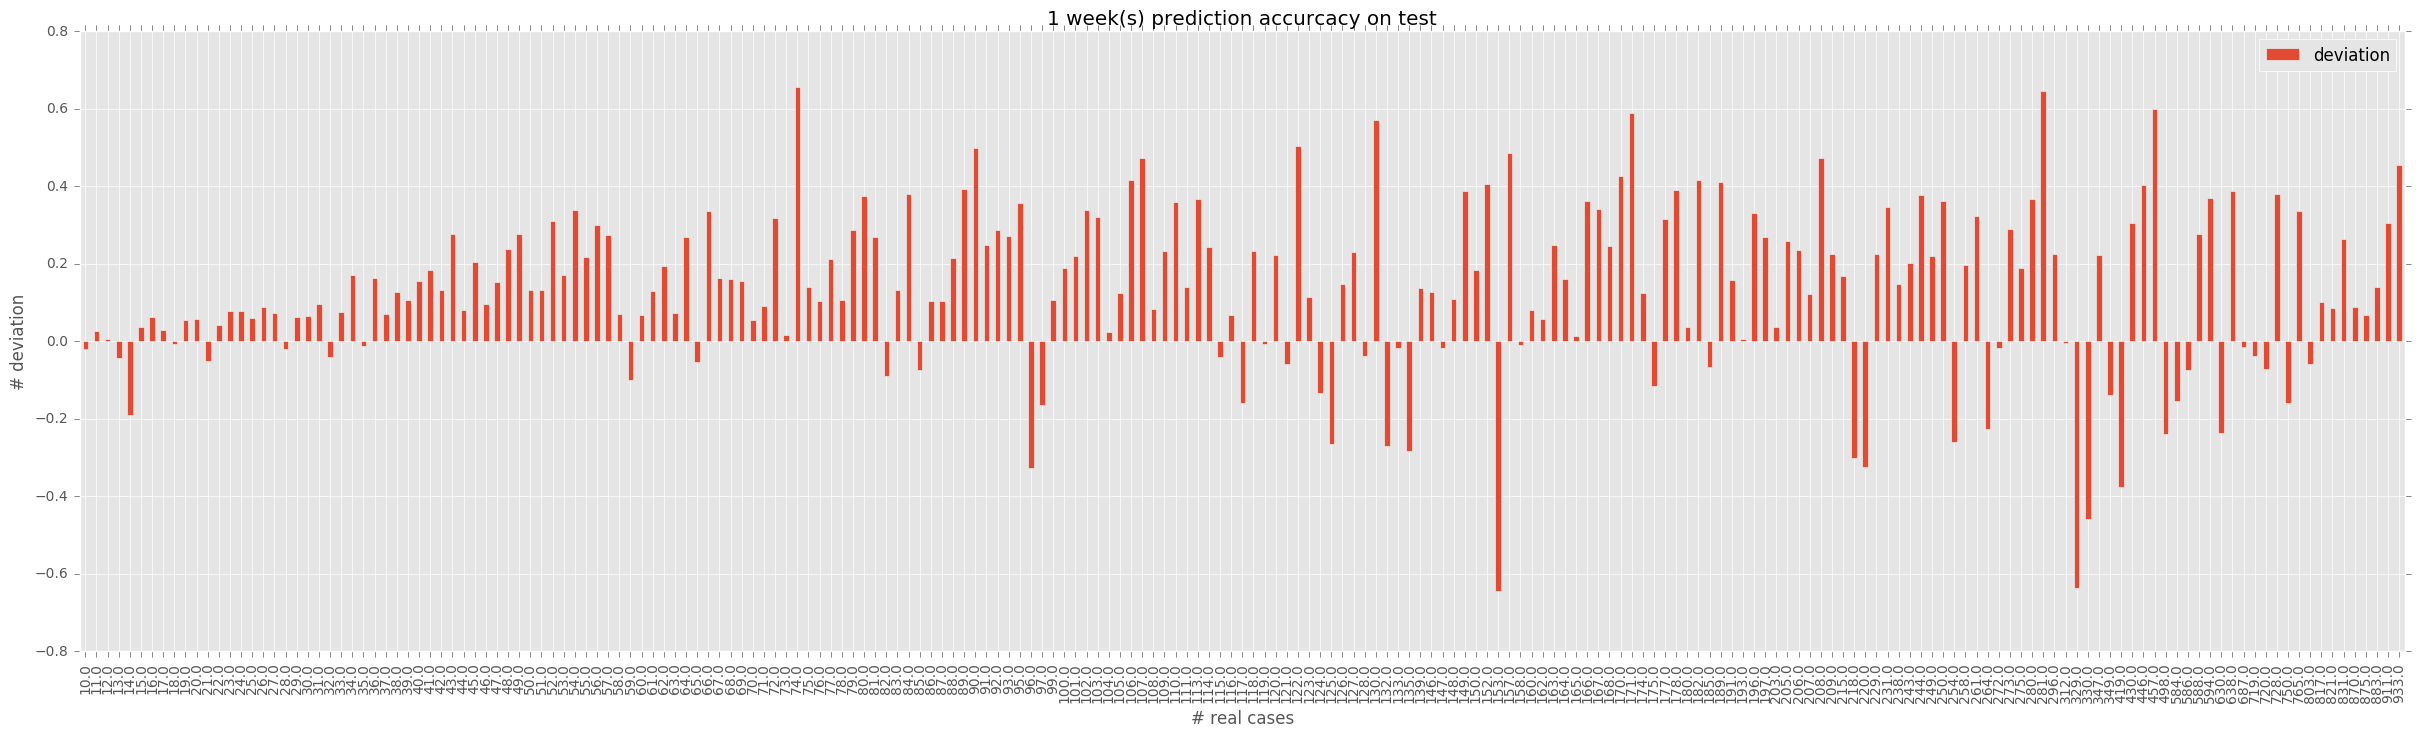

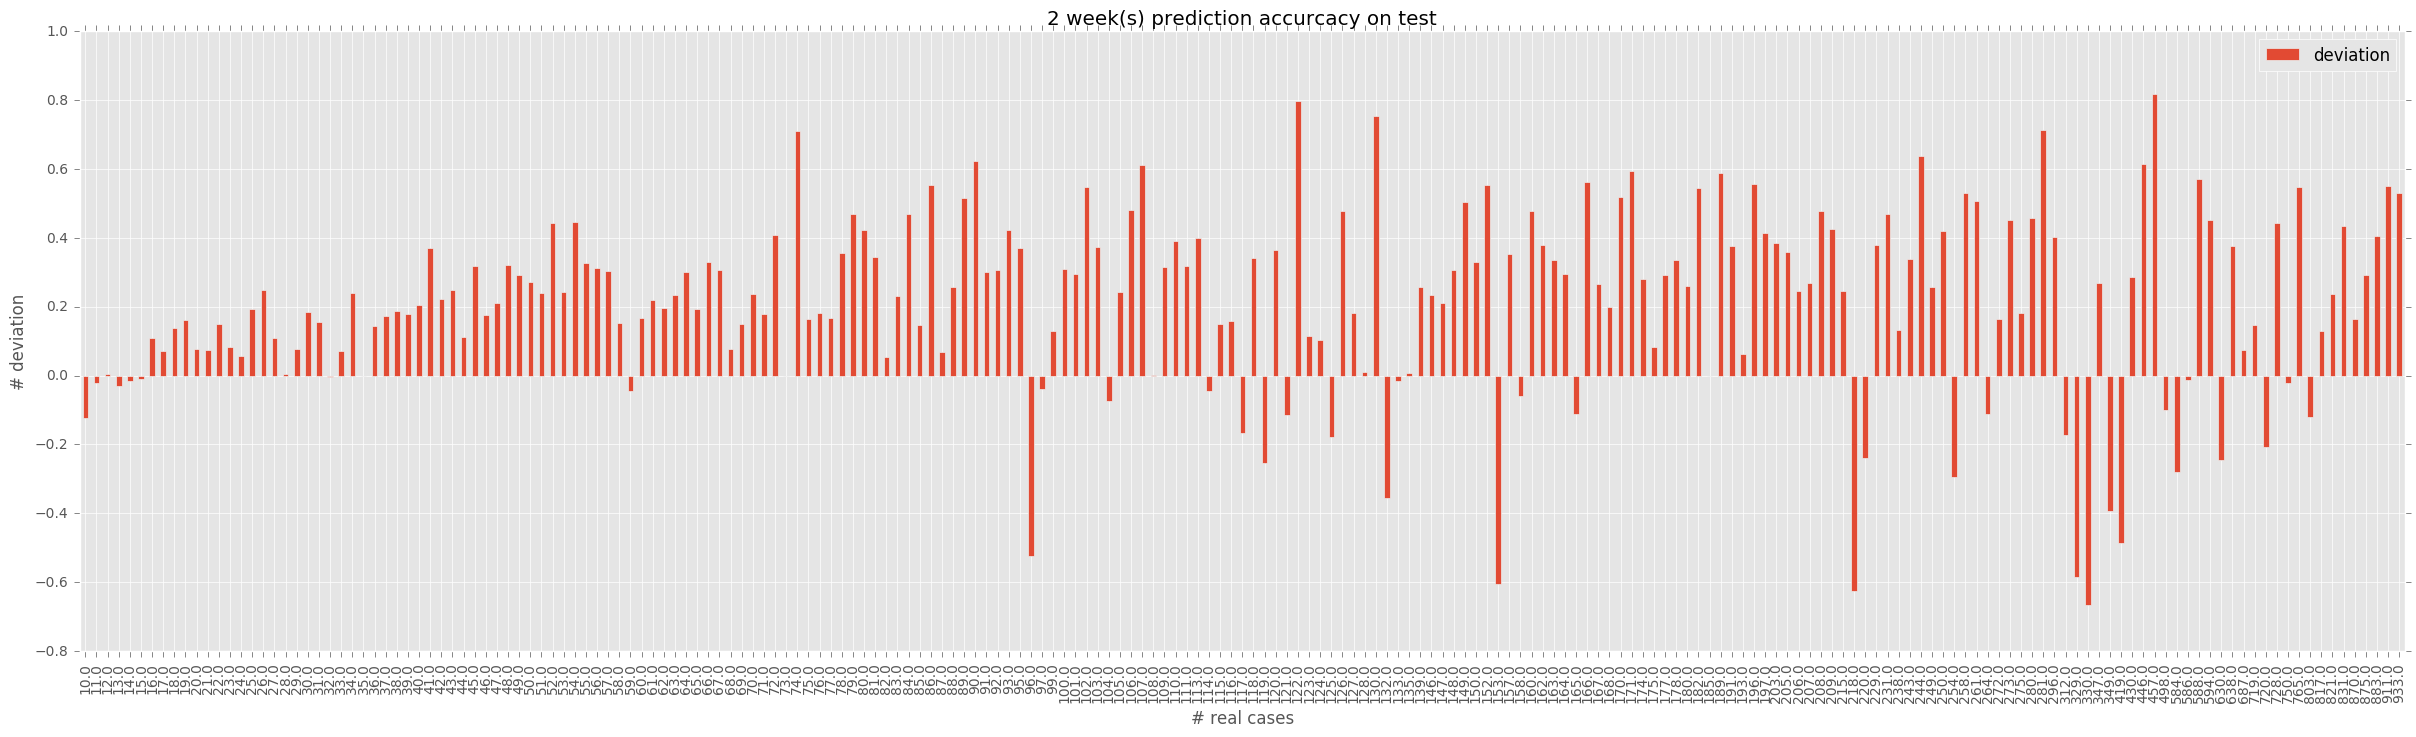

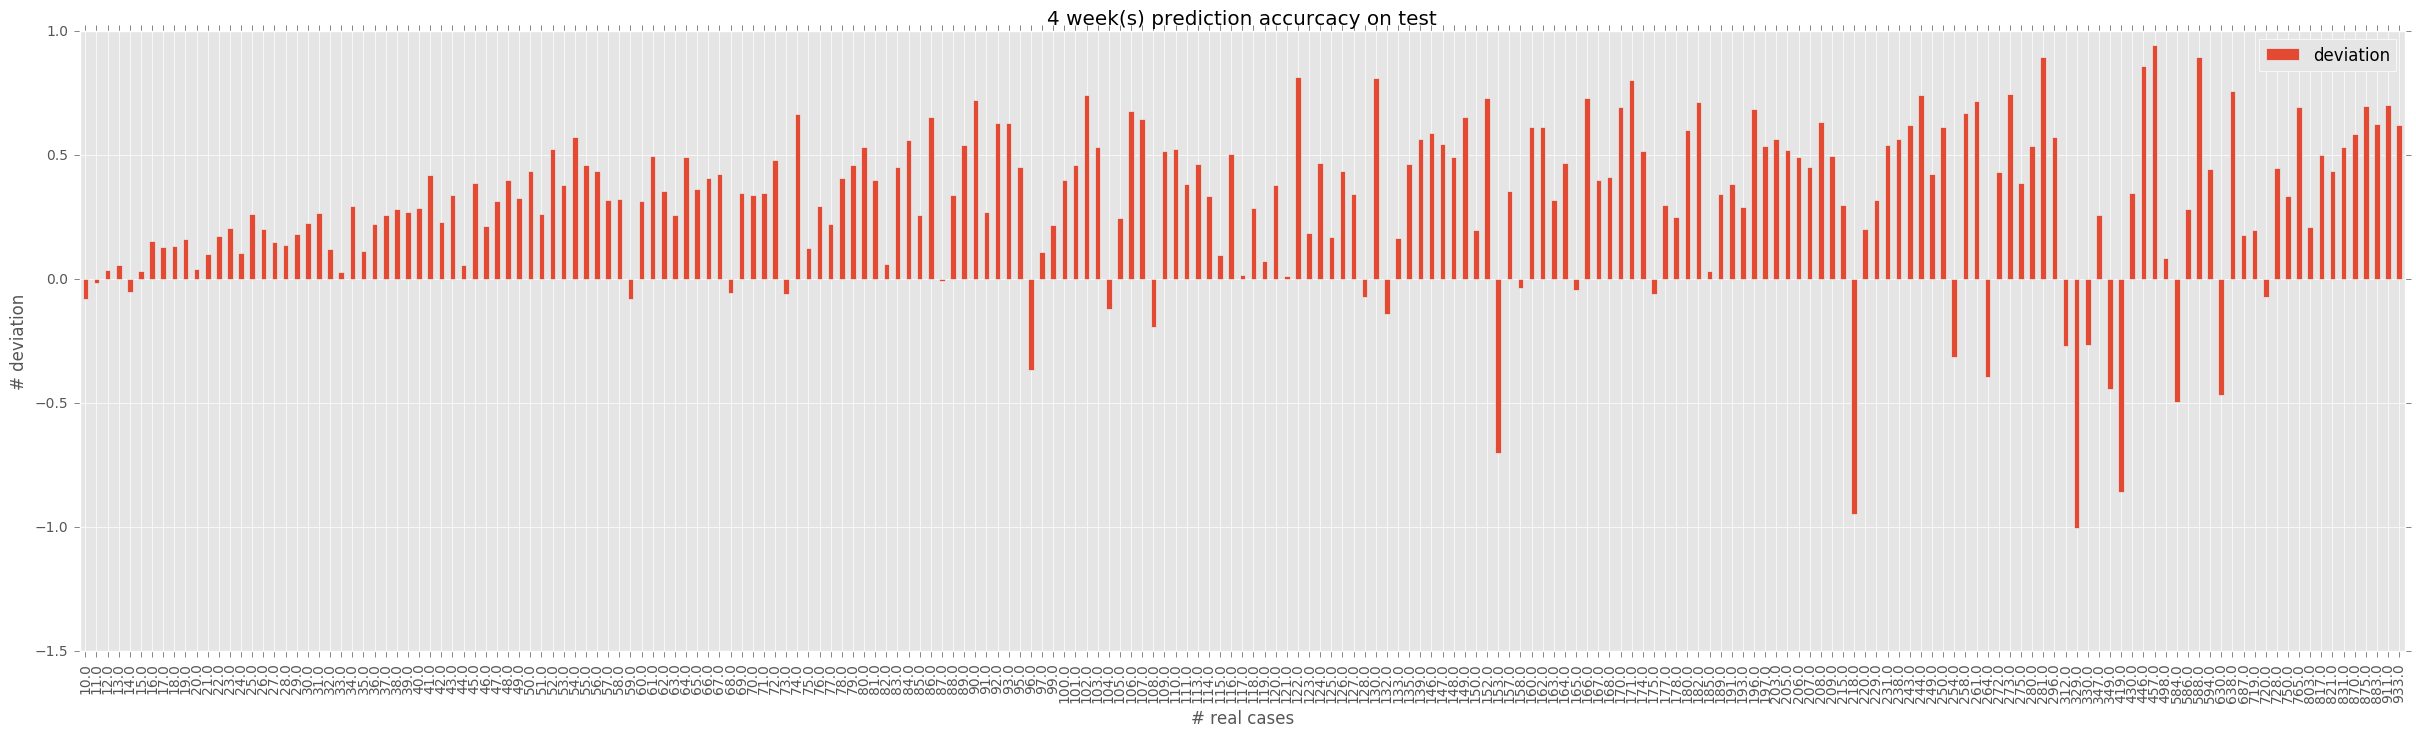

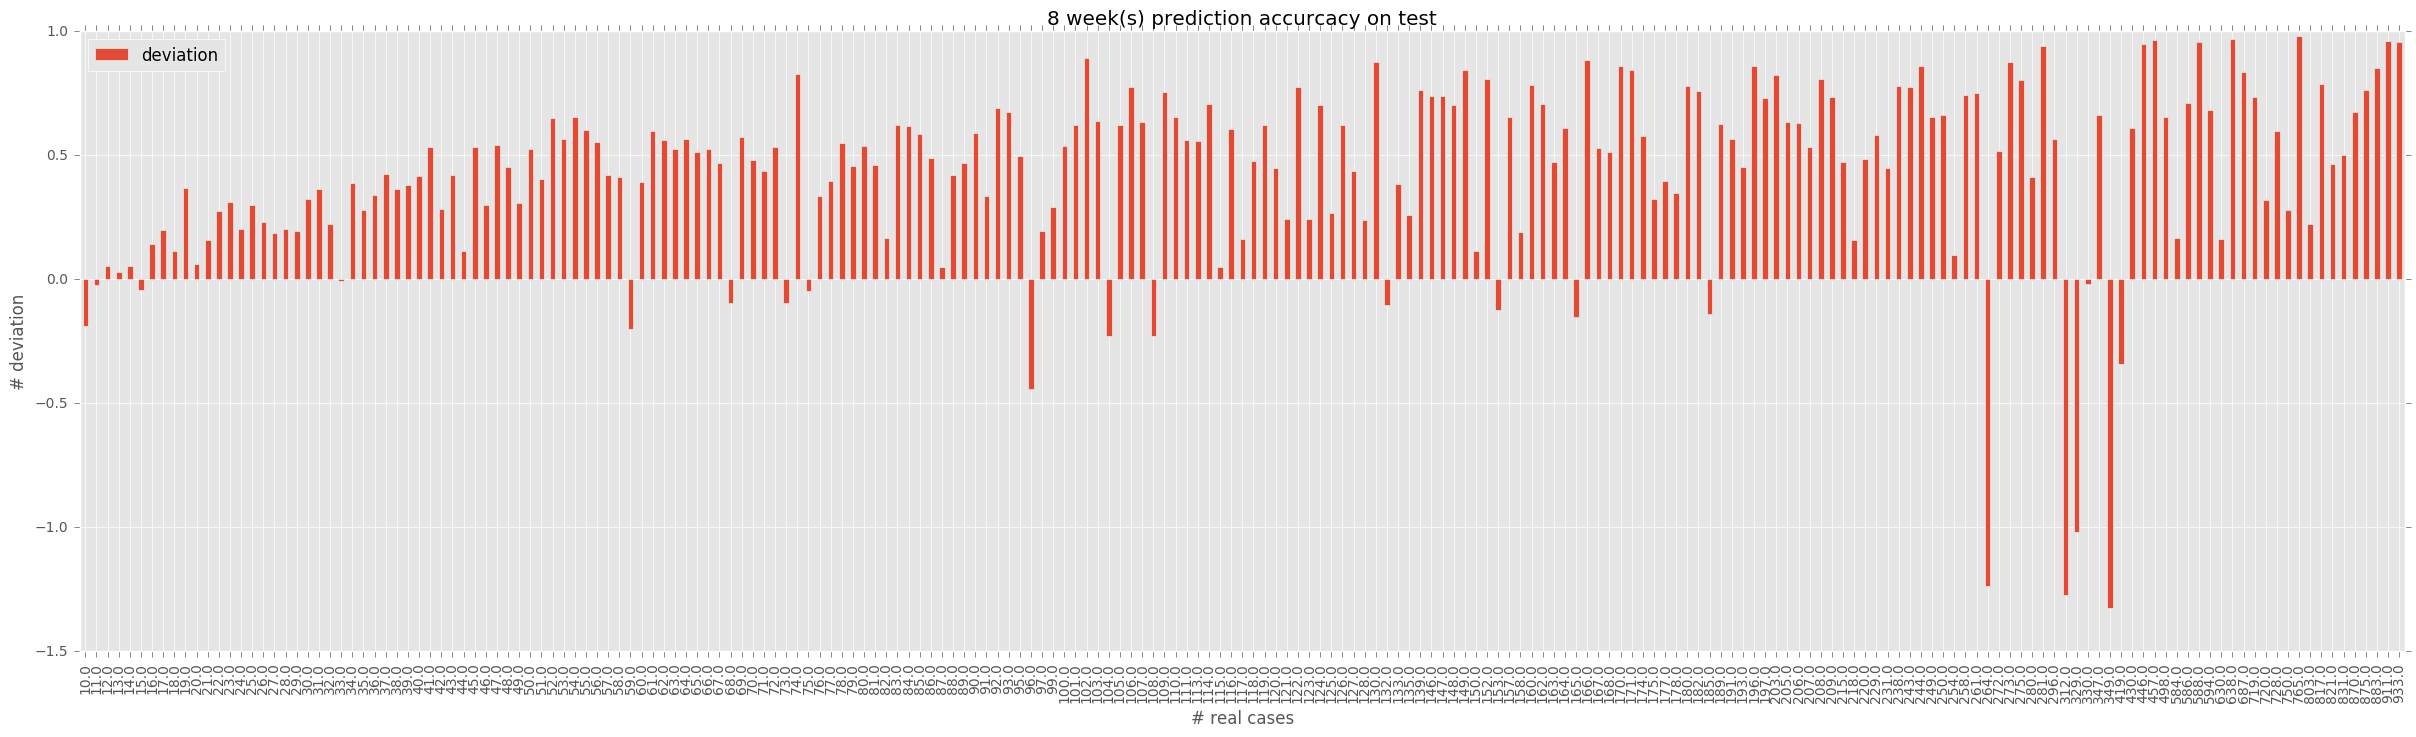

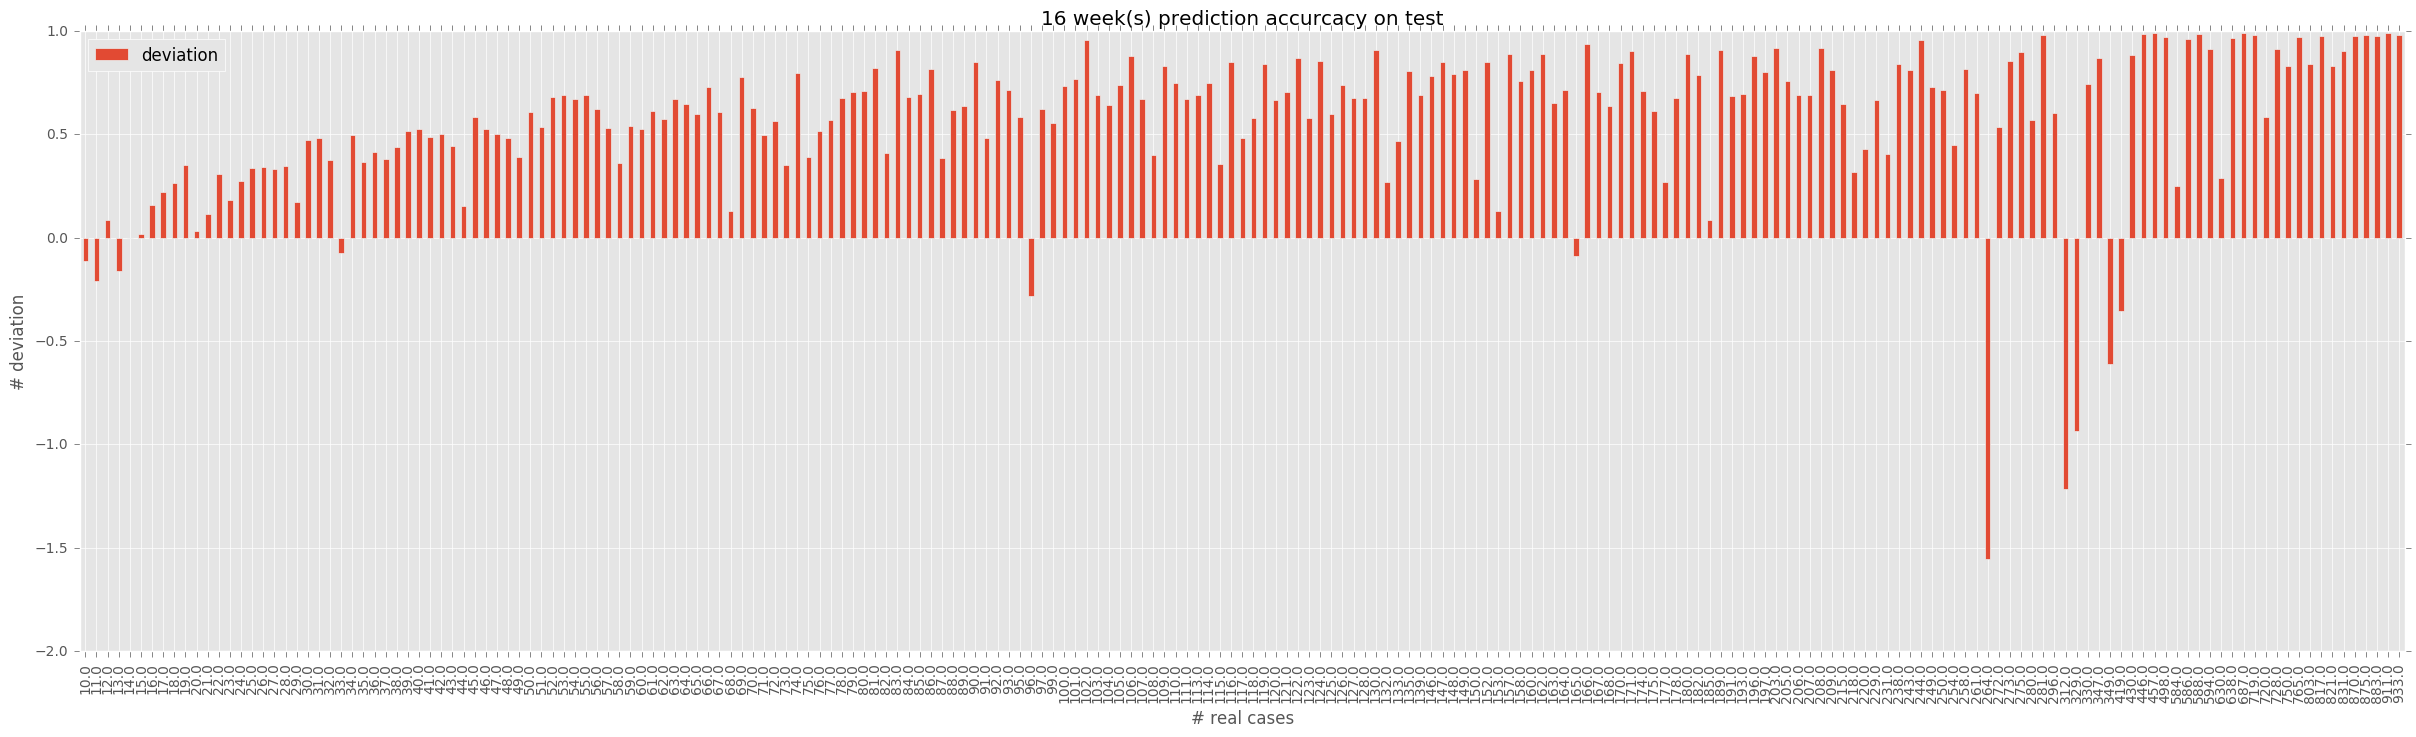

In [317]:
def combine_df(week_prediction):
    mean_week_prediction = week_prediction.mean()
    mean_week_prediction_df = pd.DataFrame(mean_week_prediction)
    mean_week_prediction_df['real_case'] = mean_week_prediction_df.index
    mean_week_prediction_df = mean_week_prediction_df.reset_index(drop=True)
    mean_week_prediction_df.columns = ['deviation','real_case']
    return mean_week_prediction_df

def plot_bar(predicted_weeks,week):
    title = "%d week(s) prediction accurcacy on test"%(week)
    predicted_weeks[10:].plot.bar(y='deviation',x='real_case',title=title,figsize=(30,8))
    plt.ylabel("# deviation")
    plt.xlabel("# real cases")

weeks_predicted = [1,2,4,8,16]
for idx, week in enumerate(weeks_predicted):
    predicted_weeks = combine_df(all_weeks_arr[idx])
    plot_bar(predicted_weeks,week)

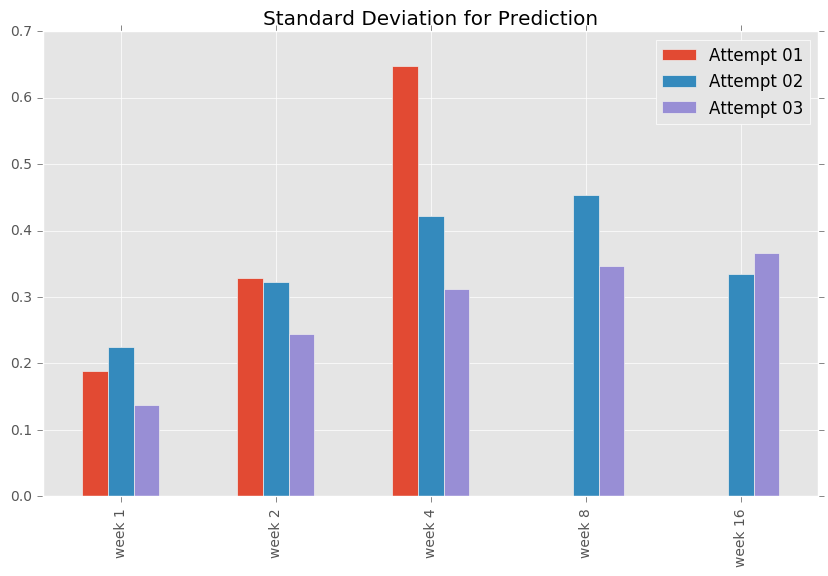

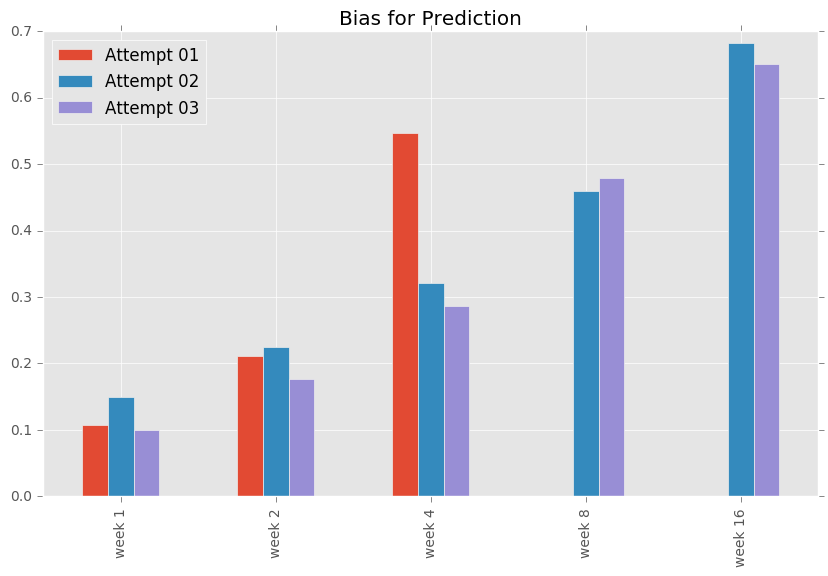

In [55]:
# plt.plot([0.189,0.329,0.648],label='Attempt 01')
# plt.plot([0.225,0.323,0.422,0.454,0.334],label='Attempt 02')
# plt.plot([0.137,0.244,0.312,0.346,0.366],label='Attempt 03')
# plt.title("Standard Deviation for Prediction")

stds = pd.DataFrame([0.189,0.329,0.648,None,None],columns=['Attempt 01'])
stds['Attempt 02'] = [0.225,0.323,0.422,0.454,0.334]
stds['Attempt 03'] = [0.137,0.244,0.312,0.346,0.366]
stds.index = ['week 1', 'week 2', 'week 4', 'week 8', 'week 16']
stds.plot.bar(figsize=(10,6),title="Standard Deviation for Prediction")
# plt.savefig('std-all-models.pdf',dpi = 300, bbox_inches='tight')

bias = pd.DataFrame([0.107,0.211,0.547,None,None],columns=['Attempt 01'])
bias['Attempt 02'] = [0.150,0.224,0.321,0.459,0.682]
bias['Attempt 03'] = [0.099,0.176,0.287,0.479,0.651]
bias.index = ['week 1', 'week 2', 'week 4', 'week 8', 'week 16']
bias.plot.bar(figsize=(10,6),title="Bias for Prediction")
# plt.savefig('bias-all-models.pdf',dpi = 300, bbox_inches='tight')